## NYC Parking Violations - Detailed Analysis and a Prediction Model

### Eren Tümkaya - tumkaya19@itu.edu.tr


In [316]:
import requests
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import calendar
import requests
from io import StringIO
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score


## About the Project

This project begins with ingesting the NYC Parking Violations data from 01-July-2022 to 30-June-2023. Cleaning, analyzing and visualising this large dataset from different angles was the inital part of the work, grouping it by date and hour features followed. 

Soon after, I ingested another dataset containing hourly weather data for respective dates. Cleaning this dataset was once again crucial before merging it with Parking Violations. This merge let me answer an important question I had planned to ask to my dataframe prior to starting my analysis: "Are weather conditions, spesifically rain, assosicated with the number of parking violations?". I approached this question from various perspectives to find the answers I needed. Although the results surprised me, I believe I can say that I was content with my findings.

Last part of the project consisted of training a machine learning model to predict hourly parking violation counts. It was mostly about preparing the features to be trained and trying different algorithms. 

Almost every code I wrote is followed by my comments on what I did, how I did it and the difficulties I had. I tried to be as open as I could during this whole project.

My problems which I set out to solve, how I dealt with them, the difficult parts, things I couldn't perform and the reasons of all can be found at the bottom of this notebook, below the project. I also included a section where I gave brief information about the resources I used and the time it took for me to finish this project.

### Getting the Data

New York City has a really nice website where most of its open data can be found easily. I used the relatively new and large dataset "Parking Violations Issued". The link to the open data site and to my dataset is [here](https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2023/869v-vr48) for anyone interested.

The site lets me access the data in various ways. I prefer to pull it using the "API" of the dataset. For that, I read the API document really carefully, checked which columns I will be using and also used paginating to retrieve it.  

Paginating is pulling the data in multiple requests instead of one. I used this because I believe it is more suitable for a large dataset.It will potentially help me with avoiding timeouts, problems with memory usage and overall performance. Again, the parameters of the API's can differ. Hence, reading the documentation is a must. For this dataset, "API" documentation can be found [here](https://dev.socrata.com/foundry/data.cityofnewyork.us/869v-vr48). 



In [4]:
url = "https://data.cityofnewyork.us/resource/869v-vr48.json"
params = {
    '$select': 'summons_number,issue_date,violation_time,violation_code,vehicle_color,vehicle_body_type,vehicle_make,vehicle_year,unregistered_vehicle,violation_county,registration_state',

    '$limit': 100000,
    '$offset': 0  
}

all_data = []

while True:
    response = requests.get(url, params=params)
    
    try:
        response.raise_for_status()
        data = response.json()
        if not data:
            break  
        all_data.extend(data)
        params['$offset'] += len(data)
    except requests.exceptions.HTTPError as error1:
        print(f"HTTP Error: {error1}")
        break
    except requests.exceptions.ConnectionError as error2:
        print(f"Error Connecting: {error2}")
        break
    except requests.exceptions.Timeout as error3:
        print(f"Timeout Error: {error3}")
        break
    except requests.exceptions.RequestException as error4:
        print(f"An error occurred: {error4}")
        break
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        break

raw_dataset = pd.DataFrame(all_data)


In [5]:
raw_dataset

,summons_number,issue_date,violation_time,violation_code,vehicle_color,vehicle_body_type,vehicle_make,vehicle_year,unregistered_vehicle,violation_county,registration_state
0,1484697303,2022-06-10T00:00:00.000,1037A,67,BLK,SDN,TOYOT,2004,0,NY,NY
1,1484697315,2022-06-13T00:00:00.000,1045A,51,GRAY,SUBN,JEEP,2017,0,NY,NY
2,1484697625,2022-06-19T00:00:00.000,1116A,63,GRAY,SDN,JEEP,0,0,NY,NJ
3,1484697674,2022-06-19T00:00:00.000,1052A,63,NaN,SUBN,LEXUS,0,0,NY,NY
4,1484697686,2022-06-19T00:00:00.000,1107A,63,BLUE,SDN,HYUND,0,0,NY,NJ
...,...,...,...,...,...,...,...,...,...,...,...
21563253,9081757568,2023-09-26T00:00:00.000,1207P,21,GY,SUBN,SUBAR,2021,NaN,NY,NY
21563254,9081822305,2023-09-22T00:00:00.000,0354P,20,BK,SUBN,JEEP,2016,NaN,BX,NY
21563255,9081860008,2023-09-16T00:00:00.000,1231P,40,GY,4DSD,INFIN,2021,NaN,K,NY
21563256,9081880056,2023-09-26T00:00:00.000,1015A,21,WH,4DSD,CADIL,2014,NaN,K,NY


In [6]:
raw_dataset.to_csv('C:\\EREN\\Datasets\\NYC_raw_data.csv')

This dataset is really large. Therefore I saved it once I ingested as a whole.

In [7]:
raw_dataset.to_parquet('C:\\EREN\\Datasets\\NYC_raw_data.parquet')

I also saved it converting it to "parquet". I am planning to use it if I have any issues with the csv format.

In [357]:
raw_dataset=pd.read_csv('C:\\EREN\\Datasets\\NYC_raw_data.csv')

In [360]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21563258 entries, 0 to 21563257
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   summons_number        int64  
 1   issue_date            object 
 2   violation_time        object 
 3   violation_code        int64  
 4   vehicle_color         object 
 5   vehicle_body_type     object 
 6   vehicle_make          object 
 7   vehicle_year          int64  
 8   unregistered_vehicle  float64
 9   violation_county      object 
 10  registration_state    object 
dtypes: float64(1), int64(3), object(7)
memory usage: 1.8+ GB


## Cleaning the Data

### The Date

In [361]:
raw_dataset["issue_date"]

0           2022-06-10T00:00:00.000
1           2022-06-13T00:00:00.000
2           2022-06-19T00:00:00.000
3           2022-06-19T00:00:00.000
4           2022-06-19T00:00:00.000
                     ...           
21563253    2023-09-26T00:00:00.000
21563254    2023-09-22T00:00:00.000
21563255    2023-09-16T00:00:00.000
21563256    2023-09-26T00:00:00.000
21563257    2023-09-25T00:00:00.000
Name: issue_date, Length: 21563258, dtype: object

I will convert the column to date format in order to perform operations easily.

In [362]:
raw_dataset['issue_date'] = pd.to_datetime(raw_dataset['issue_date'])

In [363]:
raw_dataset["issue_date"]

0          2022-06-10
1          2022-06-13
2          2022-06-19
3          2022-06-19
4          2022-06-19
              ...    
21563253   2023-09-26
21563254   2023-09-22
21563255   2023-09-16
21563256   2023-09-26
21563257   2023-09-25
Name: issue_date, Length: 21563258, dtype: datetime64[ns]

As indicated in the documentation, this dataset provides data on "Parking Violations" issued between July 1, 2022 to June 30, 2023. However, I noticed that it also includes some datas before and after these dates. I wanted to solely focus on the data mentioned on the documentation. Hence, I will delete the rest.

In [364]:
raw_dataset = raw_dataset[(raw_dataset["issue_date"] >= "2022-07-01") & (raw_dataset["issue_date"] <= "2023-06-30")]



In [365]:
raw_dataset.reset_index(drop=True, inplace=True)

In [366]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17245270 entries, 0 to 17245269
Data columns (total 11 columns):
 #   Column                Dtype         
---  ------                -----         
 0   summons_number        int64         
 1   issue_date            datetime64[ns]
 2   violation_time        object        
 3   violation_code        int64         
 4   vehicle_color         object        
 5   vehicle_body_type     object        
 6   vehicle_make          object        
 7   vehicle_year          int64         
 8   unregistered_vehicle  float64       
 9   violation_county      object        
 10  registration_state    object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 1.4+ GB


It looks better now. I move on to the next.

### The Hour 

I will start the hour column. One of the first things that I want to see is the hourly trend of parking tickets. Hence, it is an important task for me to clean it enough to be able to perform my analysis.

In [367]:
raw_dataset["violation_time"]

0           1102A
1           1132A
2           1135A
3           0235P
4           0156P
            ...  
17245265    1022P
17245266    0300A
17245267    0639P
17245268    0220A
17245269    0205A
Name: violation_time, Length: 17245270, dtype: object

There are several things that I want to do with this column. Firstly, I want to turn all these values to 24h system. Then, I will change the datatype.  

Before I move on, I want to see how many missing data points I have.

In [368]:
raw_dataset[raw_dataset["violation_time"].isnull()]

,summons_number,issue_date,violation_time,violation_code,vehicle_color,vehicle_body_type,vehicle_make,vehicle_year,unregistered_vehicle,violation_county,registration_state
338,1471587850,2022-07-04,NaN,20,GY,SDN,HYUND,2020,0.0,Q,NY
2577,1487702670,2022-07-07,NaN,40,BLK,SUBN,ACURA,0,0.0,Q,PA
300261,1487614482,2022-07-14,NaN,78,WH,VAN,ISUZU,0,0.0,Q,NJ
328072,1487881447,2022-07-02,NaN,74,BLK,NaN,BMW,0,0.0,NaN,99
995193,1485279677,2022-08-03,NaN,21,GRAY,P-U,CHEVR,2006,0.0,K,NY
...,...,...,...,...,...,...,...,...,...,...,...
17087459,1490352909,2023-06-07,NaN,46,WHT,VAN,FORD,2015,0.0,NaN,NY
17088190,1471957809,2023-06-24,NaN,40,BLK,SUBN,LEXUS,2016,0.0,K,NY
17243613,1491941078,2023-06-01,NaN,20,NaN,SDN,BMW,0,0.0,NaN,99
17243745,1492270880,2023-06-21,NaN,46,BLK,SUBN,KIA,0,0.0,NY,NY


It is quite nice to see that I don't have many. 173 rows out of 21 million is negligible. I will delete them and continue my analysis.

In [369]:
raw_dataset.dropna(subset=["violation_time"], inplace=True)

In [370]:
raw_dataset["violation_time"].isnull().sum()

0

Now, I will perform the transformation I mentioned. For this, I will define a function first. This function helps me getting rid of PM's and AM's also returning the hour for the earliest hour. 

For instance, 10.37A will be returned as 10.00 and 09.57P will be returned as 21.00. This will help me with grouping, that is the idea behind.  

*** After some inspection, I realised that there were also rows like "0000P", "0034A" etc. I don't think it is common in US to represent the hour like that but there were many tickets time labeled like this. So I prepared my function to be able to handle all of them.

Below, I wanted to show what I was talking about.


In [371]:
filtered_rows = raw_dataset[raw_dataset['violation_time'].str.startswith("00")]


In [372]:
filtered_rows

,summons_number,issue_date,violation_time,violation_code,vehicle_color,vehicle_body_type,vehicle_make,vehicle_year,unregistered_vehicle,violation_county,registration_state
237,1457742019,2022-07-05,0044A,98,RED,SUBN,CHEVR,0,0.0,BX,FL
252,1481929781,2022-07-02,0015A,40,BK,SDN,LEXUS,2022,0.0,NaN,NY
255,1481953552,2022-07-08,0050A,98,WHITE,P-U,FORD,2010,0.0,Q,NY
267,1482030706,2022-07-05,0005A,46,BLK,SDN,ME/BE,2016,0.0,NY,NY
300,1465452760,2022-07-06,0015A,17,BLK,SDN,INFIN,2014,0.0,NaN,NY
...,...,...,...,...,...,...,...,...,...,...,...
17244907,1491509296,2023-06-22,0058A,40,WH,SDN,HONDA,2010,0.0,NY,NJ
17244912,1491745460,2023-06-21,0008A,40,NaN,SUBN,BMW,2013,0.0,K,NY
17244920,1491747328,2023-06-21,0027A,78,NaN,VAN,FORD,0,0.0,K,NY
17244935,1491750856,2023-06-21,0003A,78,WHITE,VAN,CHEVR,2016,0.0,NaN,NY


Now, I will write the function to perform this transformation.

In [373]:
def convert_and_round(hour_str):
    try:
        hour, minute = hour_str[:-1][:2], hour_str[:-1][2:]
    
        if hour_str[-1] == 'P':
            if hour != '12':
                hour = str(int(hour) + 12)
        elif hour_str[-1] == 'A' and hour == '12':
            hour = '00'
    
        
        return f'{hour.zfill(2)}:00'
    except ValueError:
        return hour_str

In [374]:
convert_and_round("0027P")

'12:00'

In [375]:
convert_and_round("1220P")

'12:00'

In [376]:
convert_and_round("0020A")

'00:00'

In [377]:
convert_and_round("0320A")

'03:00'

It seems as if it is working perfectly. I will apply it to our dataframe now.

In [378]:
raw_dataset["violation_time"]=raw_dataset["violation_time"].apply(convert_and_round)

In [379]:
raw_dataset

,summons_number,issue_date,violation_time,violation_code,vehicle_color,vehicle_body_type,vehicle_make,vehicle_year,unregistered_vehicle,violation_county,registration_state
0,1484699750,2023-06-19,11:00,63,WHT,SUBN,CHEVR,2010,0.0,NY,NY
1,1484720581,2022-07-03,11:00,68,WHT,VAN,CHRYS,0,0.0,R,FL
2,1484720600,2022-07-03,11:00,68,WHT,SUBN,CHEVR,0,0.0,R,NJ
3,1484721329,2022-07-04,14:00,20,GL,SUBN,SUBAR,2016,0.0,R,NY
4,1484721330,2022-07-04,13:00,20,WHITE,SUBN,ME/BE,2019,0.0,R,NY
...,...,...,...,...,...,...,...,...,...,...,...
17245265,1492958694,2022-08-26,22:00,99,BLU,SDN,HONDA,2007,0.0,Q,PA
17245266,1492976532,2023-06-04,03:00,51,BLUE,SUBN,JEEP,0,0.0,Q,NY
17245267,1487347315,2023-06-04,18:00,46,NaN,SUBN,CHRYS,0,0.0,NaN,NY
17245268,1488236902,2022-11-19,02:00,98,BLK,SUBN,CHEVR,2022,0.0,K,NY


I will perform grouping to see if it looks fine.

In [380]:
raw_dataset.groupby(["issue_date","violation_time"]).size().sort_index().head(24)

issue_date  violation_time
2022-07-01  00:00              426
            01:00              533
            02:00              407
            03:00              245
            04:00              149
            05:00              457
            06:00             2381
            07:00             3553
            08:00             5999
            09:00             5888
            10:00             4392
            11:00             5729
            12:00             5106
            13:00             4555
            14:00             4614
            15:00             3799
            16:00             3377
            17:00             2897
            18:00             2277
            19:00             1889
            20:00             1707
            21:00             1421
            22:00              329
            23:00              265
dtype: int64

In [381]:
raw_dataset.groupby("violation_time").size().sort_index().head(35)

violation_time
.1:00          1
00:00     280161
01:00     270939
02:00     212097
03:00     181406
04:00     169762
05:00     259492
06:00     540066
07:00     952984
08:00    1471612
09:00    1503656
10:00    1223646
11:00    1503414
12:00    1395900
13:00    1346455
14:00    1194043
15:00     998139
16:00     800483
17:00     692311
18:00     506686
19:00     384778
20:00     384651
21:00     361539
22:00     317452
23:00     293396
25:00          1
26:00          1
27:00          2
28:00          1
29:00          1
30:00          1
31:00          1
32:00          1
43:00          1
45:00          2
dtype: int64

It looks really good. There are some which are probably wrong imputs and I will drop them.

I will use regular expressions to remove all the rest. 

In [382]:
filter1 = raw_dataset["violation_time"].str.match(r'^([01]\d|2[0-3]):00$')
filtered_dataset = raw_dataset[filter1]

Lastly, I want to convert my column datatype to categorical. I also want them to be ordered so I defined "ordered categories".

In [383]:
ordered_categories = ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']

filtered_dataset["violation_time"] = pd.Categorical(filtered_dataset["violation_time"], categories=ordered_categories, ordered=True)

C:\Users\erent\AppData\Local\Temp\ipykernel_28844\1078268269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset["violation_time"] = pd.Categorical(filtered_dataset["violation_time"], categories=ordered_categories, ordered=True)


In [384]:
filtered_dataset.groupby("violation_time").size()

violation_time
00:00     280161
01:00     270939
02:00     212097
03:00     181406
04:00     169762
05:00     259492
06:00     540066
07:00     952984
08:00    1471612
09:00    1503656
10:00    1223646
11:00    1503414
12:00    1395900
13:00    1346455
14:00    1194043
15:00     998139
16:00     800483
17:00     692311
18:00     506686
19:00     384778
20:00     384651
21:00     361539
22:00     317452
23:00     293396
dtype: int64

I believe I am done with this feature as well.

## Initial Analysis

Since the date and hour features are cleaned now, I wanted to visualize them to gain some first insight on the data.

### Average Count of Parking Violations Each Hour

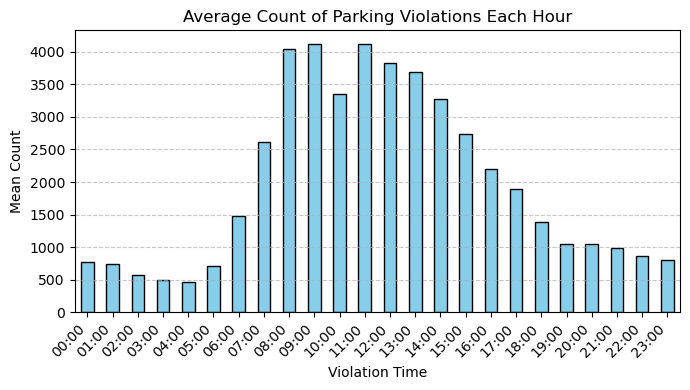

In [385]:
grouped_data = filtered_dataset.groupby(["issue_date", "violation_time"]).size().groupby("violation_time").mean()


fig, ax = plt.subplots(figsize=(7, 4))

grouped_data.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)


ax.set_xlabel('Violation Time')
ax.set_ylabel('Mean Count')
ax.set_title('Average Count of Parking Violations Each Hour')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45, ha='right') 
plt.tight_layout()

plt.show()

As I expected the night time and close to sunset have the lowest number of parking violations. It peaks during the midday.

### Monthly Parking Violations

In [386]:
filtered_dataset = filtered_dataset.sort_values(by='issue_date')


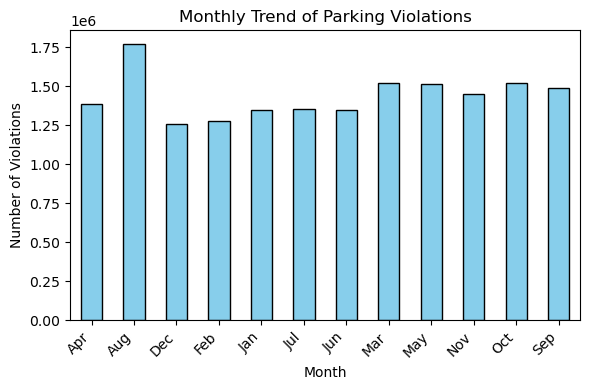

In [387]:
filtered_dataset['month'] = filtered_dataset['issue_date'].dt.month.apply(lambda x: calendar.month_abbr[x])

monthly = filtered_dataset.groupby('month').size()

fig, ax = plt.subplots(figsize=(6, 4))

monthly.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)

ax.set_xlabel('Month')
ax.set_ylabel('Number of Violations')
ax.set_title('Monthly Trend of Parking Violations')

plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

plt.show()

### Violations by County - Five boroughs of New York City

This dataset also provides info on the parking violations based on in which borough of NYC they occured. This data is not clean. I will show it below.

In [388]:
filtered_dataset["violation_county"].value_counts()

violation_county
NY       3697695
QN       2696312
BK       2494537
BX       2244984
K        2119824
Q        1901935
MN        850034
ST        486555
Kings     275584
Bronx     150322
R         146856
Qns        83270
Rich        1451
QNS            8
QUEEN          7
ABX            1
K   F          1
KINGS          1
Name: count, dtype: int64

This colum has many typos which is preventing me from grouping and visualising them in a nice way. I will correct the names to continue my analysis.

I will correct the names of the ones which include quite some number of data. I will use the the names of the boroughs indicated [here](https://en.wikipedia.org/wiki/List_of_counties_in_New_York#:~:text=They%20are%20New%20York%20County,and%20Queens%20County%20(Queens).)

In [389]:
MAP = {'NY': 'Manhattan', 'MN': 'Manhattan', 'BK': 'Brooklyn', 'K': 'Brooklyn','K   F': 'Brooklyn','Kings': 'Brooklyn',\
       'KINGS': 'Brooklyn','BX': 'Bronx','ABX': 'Bronx','QN': 'Queens','Q': 'Queens','Qns': 'Queens','QNS': 'Queens',\
     'QUEEN': 'Queens', 'ST':'Staten Island','R':'Staten Island','Rich':'Staten Island'}  


filtered_dataset["violation_county"] = filtered_dataset["violation_county"].replace(MAP)

In [390]:
filtered_dataset["violation_county"].value_counts()

violation_county
Brooklyn         4889947
Queens           4681532
Manhattan        4547729
Bronx            2395307
Staten Island     634862
Name: count, dtype: int64

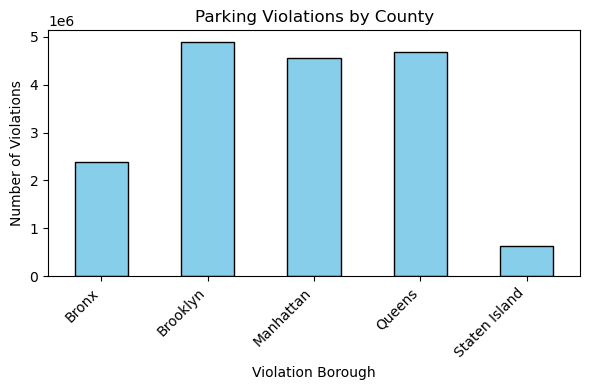

In [391]:
boroughs5 =filtered_dataset.groupby('violation_county').size()

fig, ax = plt.subplots(figsize=(6, 4))

boroughs5.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)

ax.set_xlabel('Violation Borough')
ax.set_ylabel('Number of Violations')
ax.set_title('Parking Violations by County')

plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

plt.show()

## Historical Weather Data

As I also talked about in my proposal, one of my main questions is to see the effects of the weather on parking violations. I began my search to find the suitable data for my analysis.  

Finding the hourly historical data was a bit harder than I initially thought. Iowa State University has a really nice site where  "IEM" (Iowa Environmental Mesonet) offers and maintains various station data. I am leaving the link [here](https://mesonet.agron.iastate.edu/request/download.phtml?network=NY_ASOS) for anyone interested.  

Here, I chose the New York ASOS Network and then chose the New York City as my station. The cite offers all the data that I was planning to use for this project: Air Temperature (C), 1 Hour Precipitation (mm).  

After selecting the data and the parameteres, such as format, missing value representation, trace data representation, I wanted to obtain a link on web which I can easily ingest the dataset without needing to download the data to my local device. The site also offers that. It might be important to say that I did a little modificication to the link to see if I can get all the files I needed in one call. It worked as I expected.



In [392]:
url = "https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=NYC&data=p01m&data=tmpc&year1=2022&month1=7&day1=1&year2=2023&month2=6&day2=30&tz=America%2FNew_York&format=onlycomma&latlon=no&elev=no&missing=null&trace=T&direct=no&report_type=3"


response = requests.get(url)


if response.status_code == 200:
    data_csv = StringIO(response.text)

    weather_raw_data = pd.read_csv(data_csv)

    print(weather_raw_data.head())
else:
    print(f"Error: {response.status_code}")

  station             valid  p01m   tmpc
0     NYC  2022-07-01 00:51  0.00  24.44
1     NYC  2022-07-01 01:51  0.00  24.44
2     NYC  2022-07-01 02:51  0.00  23.89
3     NYC  2022-07-01 03:51  0.00  23.33
4     NYC  2022-07-01 04:51  0.00  23.33


### Cleaning the Weather Data

Before I merge with my main dataset, I will perform cleaning and transforming to this dataset. 

I will start by seperating the date and the hour columns. I need to do this to be able merge.

In [393]:
weather_raw_data

,station,valid,p01m,tmpc
0,NYC,2022-07-01 00:51,0.00,24.44
1,NYC,2022-07-01 01:51,0.00,24.44
2,NYC,2022-07-01 02:51,0.00,23.89
3,NYC,2022-07-01 03:51,0.00,23.33
4,NYC,2022-07-01 04:51,0.00,23.33
...,...,...,...,...
8685,NYC,2023-06-29 19:51,0.00,24.44
8686,NYC,2023-06-29 20:51,0.00,23.33
8687,NYC,2023-06-29 21:51,0.00,23.33
8688,NYC,2023-06-29 22:51,0.00,22.78


In [394]:
weather_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8690 entries, 0 to 8689
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   station  8690 non-null   object 
 1   valid    8690 non-null   object 
 2   p01m     8690 non-null   object 
 3   tmpc     8690 non-null   float64
dtypes: float64(1), object(3)
memory usage: 271.7+ KB


In [395]:
weather_raw_data['valid'] = pd.to_datetime(weather_raw_data['valid'])

weather_raw_data['date'] = weather_raw_data['valid'].dt.date
weather_raw_data['time'] = weather_raw_data['valid'].dt.time

weather_raw_data["date"]=pd.to_datetime(weather_raw_data["date"])

In [396]:
weather_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8690 entries, 0 to 8689
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   station  8690 non-null   object        
 1   valid    8690 non-null   datetime64[ns]
 2   p01m     8690 non-null   object        
 3   tmpc     8690 non-null   float64       
 4   date     8690 non-null   datetime64[ns]
 5   time     8690 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 407.5+ KB


Splitting the dataset looks fine.

In [397]:
weather_raw_data

,station,valid,p01m,tmpc,date,time
0,NYC,2022-07-01 00:51:00,0.00,24.44,2022-07-01,00:51:00
1,NYC,2022-07-01 01:51:00,0.00,24.44,2022-07-01,01:51:00
2,NYC,2022-07-01 02:51:00,0.00,23.89,2022-07-01,02:51:00
3,NYC,2022-07-01 03:51:00,0.00,23.33,2022-07-01,03:51:00
4,NYC,2022-07-01 04:51:00,0.00,23.33,2022-07-01,04:51:00
...,...,...,...,...,...,...
8685,NYC,2023-06-29 19:51:00,0.00,24.44,2023-06-29,19:51:00
8686,NYC,2023-06-29 20:51:00,0.00,23.33,2023-06-29,20:51:00
8687,NYC,2023-06-29 21:51:00,0.00,23.33,2023-06-29,21:51:00
8688,NYC,2023-06-29 22:51:00,0.00,22.78,2023-06-29,22:51:00


Now I can safely drop the unneccesary columns. I have what I need.

In [398]:
weather_raw_data.drop(["valid", "station"], axis=1, inplace=True)


In [399]:
weather_raw_data = weather_raw_data[['date', 'time', 'p01m', 'tmpc']]

In [400]:
weather_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8690 entries, 0 to 8689
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8690 non-null   datetime64[ns]
 1   time    8690 non-null   object        
 2   p01m    8690 non-null   object        
 3   tmpc    8690 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 271.7+ KB


In [401]:
weather_raw_data

,date,time,p01m,tmpc
0,2022-07-01,00:51:00,0.00,24.44
1,2022-07-01,01:51:00,0.00,24.44
2,2022-07-01,02:51:00,0.00,23.89
3,2022-07-01,03:51:00,0.00,23.33
4,2022-07-01,04:51:00,0.00,23.33
...,...,...,...,...
8685,2023-06-29,19:51:00,0.00,24.44
8686,2023-06-29,20:51:00,0.00,23.33
8687,2023-06-29,21:51:00,0.00,23.33
8688,2023-06-29,22:51:00,0.00,22.78


What I want to do is to transform each hour to the next whole hour, since they are just 9 minutes away from it.

In [402]:
weather_raw_data['time'] = pd.to_datetime(weather_raw_data['time'], format='%H:%M:%S')



weather_raw_data['rounded_time'] = weather_raw_data['time'] + pd.to_timedelta(30, unit='T')  
weather_raw_data['rounded_time'] = weather_raw_data['rounded_time'].dt.strftime('%H:%M')


What I did was to add 30 minutes to each hour. This way, when I perform splitting later, I will have a time feature which is rounded to the next whole hour as I initially wanted. 

In [403]:
weather_raw_data['rounded_time']

0       01:21
1       02:21
2       03:21
3       04:21
4       05:21
        ...  
8685    20:21
8686    21:21
8687    22:21
8688    23:21
8689    00:21
Name: rounded_time, Length: 8690, dtype: object

This is where I perform my transformation.

In [404]:
weather_raw_data['rounded_time'] = weather_raw_data['rounded_time'].str.split(':').str[0] + ':00'

In [405]:
weather_raw_data.drop(["time"],axis=1,inplace=True)


I will correct the ordering of my features and then move on to renaming some features for better understanding.

In [406]:
weather_raw_data = weather_raw_data[['date', 'rounded_time', 'p01m', 'tmpc']]
weather_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8690 entries, 0 to 8689
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          8690 non-null   datetime64[ns]
 1   rounded_time  8690 non-null   object        
 2   p01m          8690 non-null   object        
 3   tmpc          8690 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 271.7+ KB


In [407]:
weather_raw_data.rename(columns={'p01m': 'precipitation (mm)',"tmpc":"Temperature (C)"}, inplace=True)


In [408]:
weather_raw_data.head(30)

,date,rounded_time,precipitation (mm),Temperature (C)
0,2022-07-01,01:00,0.00,24.44
1,2022-07-01,02:00,0.00,24.44
2,2022-07-01,03:00,0.00,23.89
3,2022-07-01,04:00,0.00,23.33
4,2022-07-01,05:00,0.00,23.33
5,2022-07-01,06:00,0.00,22.78
6,2022-07-01,07:00,0.00,23.33
7,2022-07-01,08:00,0.00,24.44
8,2022-07-01,09:00,0.00,25.56
9,2022-07-01,10:00,0.00,26.67


It is also important to mention that some rows of the precipitation data are named as "T". This tells us that the amount is really low. Since the amount can be considered negligible, I will assign 0 to them.

In [409]:
weather_raw_data["precipitation (mm)"] = weather_raw_data["precipitation (mm)"].apply(lambda x: 0.00 if x == "T" else float(x))


Lastly, I will turn the hour column to an ordered categorical column just like I did for my main dataset.

In [410]:


weather_raw_data["rounded_time"] = pd.Categorical(weather_raw_data["rounded_time"], categories=ordered_categories, ordered=True)

The dataset looks ready to be merged now.

*** Later on I realised that I made a minor mistake here. I accidently appointed each 00.00 hour the previous days date whilst it should have represented the start of the next day. I am correcting it below.

In [411]:
weather_raw_data['date'] = weather_raw_data.apply(lambda row: row['date'] + pd.DateOffset(days=1) if row['rounded_time'] == '00:00' else row['date'], axis=1)

### Merging the Datasets

#### Grouping the Parking Violation Dataset by Date and Hour

I will perform the "join" of two dataframes which I believe that I can say I managed to clear.

In [412]:
filtered_dataset

,summons_number,issue_date,violation_time,violation_code,vehicle_color,vehicle_body_type,vehicle_make,vehicle_year,unregistered_vehicle,violation_county,registration_state,month
832148,8951625266,2022-07-01,15:00,14,BL,4DSD,HONDA,2010,NaN,Manhattan,NY,Jul
681715,8872942925,2022-07-01,14:00,71,WH,DELV,HIN,2019,NaN,Manhattan,NY,Jul
681716,8872942937,2022-07-01,14:00,37,BK,VAN,FORD,2019,NaN,Manhattan,NY,Jul
681717,8872942949,2022-07-01,14:00,20,BROWN,DELV,FRUEH,2016,NaN,Manhattan,NY,Jul
681718,8872942950,2022-07-01,14:00,20,GY,SUBN,JEEP,2022,NaN,Manhattan,NY,Jul
...,...,...,...,...,...,...,...,...,...,...,...,...
17133774,4848921314,2023-06-30,18:00,36,WH,FLAT,ISUZU,2010,NaN,Staten Island,NY,Jun
17044127,4848899904,2023-06-30,15:00,36,BK,4DSD,AUDI,2013,NaN,Staten Island,NY,Jun
17044126,4848899886,2023-06-30,15:00,36,WH,SUBN,NISSA,2009,NaN,Brooklyn,NY,Jun
17207778,8797492231,2023-06-30,12:00,14,SILVE,SUBN,DODGE,0,NaN,Manhattan,IL,Jun


In [413]:
grouped_parking_data = filtered_dataset.copy().groupby(["issue_date", "violation_time"]).agg({ "summons_number":"count","month": "first"}).reset_index()


In [414]:
grouped_parking_data

,issue_date,violation_time,summons_number,month
0,2022-07-01,00:00,426,Jul
1,2022-07-01,01:00,533,Jul
2,2022-07-01,02:00,407,Jul
3,2022-07-01,03:00,245,Jul
4,2022-07-01,04:00,149,Jul
...,...,...,...,...
8755,2023-06-30,19:00,1209,Jun
8756,2023-06-30,20:00,1025,Jun
8757,2023-06-30,21:00,853,Jun
8758,2023-06-30,22:00,962,Jun


In [415]:
weather_raw_data

,date,rounded_time,precipitation (mm),Temperature (C)
0,2022-07-01,01:00,0.0,24.44
1,2022-07-01,02:00,0.0,24.44
2,2022-07-01,03:00,0.0,23.89
3,2022-07-01,04:00,0.0,23.33
4,2022-07-01,05:00,0.0,23.33
...,...,...,...,...
8685,2023-06-29,20:00,0.0,24.44
8686,2023-06-29,21:00,0.0,23.33
8687,2023-06-29,22:00,0.0,23.33
8688,2023-06-29,23:00,0.0,22.78


In [416]:
merged_violation=pd.merge(grouped_parking_data,weather_raw_data,left_on=["issue_date","violation_time"],right_on=["date","rounded_time"])

In [417]:
merged_violation

,issue_date,violation_time,summons_number,month,date,rounded_time,precipitation (mm),Temperature (C)
0,2022-07-01,01:00,533,Jul,2022-07-01,01:00,0.0,24.44
1,2022-07-01,02:00,407,Jul,2022-07-01,02:00,0.0,24.44
2,2022-07-01,03:00,245,Jul,2022-07-01,03:00,0.0,23.89
3,2022-07-01,04:00,149,Jul,2022-07-01,04:00,0.0,23.33
4,2022-07-01,05:00,457,Jul,2022-07-01,05:00,0.0,23.33
...,...,...,...,...,...,...,...,...
8685,2023-06-29,20:00,939,Jun,2023-06-29,20:00,0.0,24.44
8686,2023-06-29,21:00,817,Jun,2023-06-29,21:00,0.0,23.33
8687,2023-06-29,22:00,891,Jun,2023-06-29,22:00,0.0,23.33
8688,2023-06-29,23:00,843,Jun,2023-06-29,23:00,0.0,22.78


I will drop the unnecassary columns and rename to summons column for better interpretebility.

In [418]:
merged_violation.drop(["date","rounded_time"],axis=1,inplace=True)

In [419]:
merged_violation.rename(columns={"summons_number":"violation_count"},inplace=True)

In [420]:
merged_violation

,issue_date,violation_time,violation_count,month,precipitation (mm),Temperature (C)
0,2022-07-01,01:00,533,Jul,0.0,24.44
1,2022-07-01,02:00,407,Jul,0.0,24.44
2,2022-07-01,03:00,245,Jul,0.0,23.89
3,2022-07-01,04:00,149,Jul,0.0,23.33
4,2022-07-01,05:00,457,Jul,0.0,23.33
...,...,...,...,...,...,...
8685,2023-06-29,20:00,939,Jun,0.0,24.44
8686,2023-06-29,21:00,817,Jun,0.0,23.33
8687,2023-06-29,22:00,891,Jun,0.0,23.33
8688,2023-06-29,23:00,843,Jun,0.0,22.78


My merged violation frame looks fine to me. I will do some analysis now.

In [421]:
merged_violation.isna().sum()

issue_date            0
violation_time        0
violation_count       0
month                 0
precipitation (mm)    0
Temperature (C)       0
dtype: int64

## Are Rain and Number of Parking Violations Associated?

I had different ideas to perform this analysis. Initially, I wanted to compare the differences between daily averages where a day had rain and didn't have rain. However, I believe there was an issue with doing that. The hour of the day has a really large effect on the number of violations and which hour of the day had rain is not equally distributed in our frame, of course as expected, this makes it harder to compare the averages and get a reliable result.  

Hence, I decided to compare the hourly averages. I will take the mean parking violations of each hour without rain and also take the averages of each hour with rain. Let's see if I will be succesful to obtain an answer.

 

In [422]:
merged_violation["precipitation (mm)"].value_counts()

precipitation (mm)
0.00     8075
0.25      184
0.51       73
1.02       53
0.76       44
1.78       34
1.27       33
1.52       32
2.03       20
2.79       16
2.54       14
2.29       13
3.05       12
3.56       11
3.30       10
4.06        9
4.83        8
5.08        6
6.10        6
6.35        3
3.81        3
5.33        3
4.57        2
5.59        2
9.91        2
8.64        2
16.76       2
12.95       2
6.60        1
15.75       1
7.37        1
5.84        1
7.87        1
10.16       1
8.13        1
7.62        1
11.43       1
24.89       1
4.32        1
18.54       1
33.78       1
21.34       1
6.86        1
8.38        1
Name: count, dtype: int64

Firstly, I will convert the rain feature to 1 and 0 based on whether that hour had any.  

In [423]:
merged_violation_rain1=merged_violation.copy()

In [424]:
merged_violation_rain1["precipitation (mm)"] = merged_violation_rain1["precipitation (mm)"].apply(lambda x: 1 if x != 0 else 0)


I will check if I have enough data for each hour. I performed this to see how many hours NYC had rainfall in total. 

In [425]:
grouped_for_seeing_counts = merged_violation_rain1.groupby(['precipitation (mm)', 'violation_time'])['violation_count'].count().reset_index()


In [426]:
grouped_for_seeing_counts.rename(columns={"violation_count":"Number of days"})

,precipitation (mm),violation_time,Number of days
0,0,00:00,336
1,0,01:00,341
2,0,02:00,334
3,0,03:00,337
4,0,04:00,340
5,0,05:00,337
6,0,06:00,340
7,0,07:00,336
8,0,08:00,340
9,0,09:00,344


Rainy hours are a lot less than the ones without rain. But the number of rainy days for each hour showed me that when I take the mean and group, I can get valuable information for comparision. 

I will perform cross tabing in order to see the average parking violations for each hour for first when it rains and then when it doesn't.

In [427]:
cross_tab_mean = pd.crosstab(index=merged_violation_rain1['violation_time'], columns=merged_violation_rain1['precipitation (mm)'], values=merged_violation_rain1['violation_count'], aggfunc='mean')


In [428]:
cross_tab_mean.columns=["No Rain","Rain"]

In [429]:
cross_tab_mean

,No Rain,Rain
violation_time,,
00:00,784.880952,571.964286
01:00,759.307918,495.809524
02:00,593.416168,459.741935
03:00,505.029674,374.920000
04:00,474.355882,315.913043
05:00,720.605341,563.115385
06:00,1497.223529,1196.739130
07:00,2638.446429,2232.038462
08:00,4076.194118,3480.863636


This table was really surprising for me. Definietly didn't expect that. For all hours of the day, average parking violations were lower in rainy days compared the no rain days.  
I will perform a statistical test to find out whether I can reject the null hyphothesis that they are associated. I will use "log-likelihood" arguement instead of "pearson" because my sample size is relatively small.

In [430]:
chi2_contingency(cross_tab_mean,lambda_="log-likelihood")

Chi2ContingencyResult(statistic=170.8521609209994, pvalue=1.4530088467987859e-24, dof=23, expected_freq=array([[ 763.82959342,  593.01564468],
       [ 706.56241277,  548.55502893],
       [ 592.8703607 ,  460.28774244],
       [ 495.36349654,  384.58617705],
       [ 444.8781448 ,  345.39078103],
       [ 722.66449597,  561.05622989],
       [1516.55350616, 1177.40915369],
       [2741.81637588, 2128.66851423],
       [4254.20983145, 3302.84792256],
       [4120.01979077, 3198.66657874],
       [3456.64470023, 2683.6409626 ],
       [4438.01939156, 3445.55245473],
       [3924.85434284, 3047.14565716],
       [3739.08883235, 2902.92258057],
       [3354.35774866, 2604.22827284],
       [2641.45711985, 2050.75243264],
       [2181.40718054, 1693.58270042],
       [1865.57768606, 1448.38163346],
       [1383.01645188, 1073.73477001],
       [1008.82664233,  783.22440872],
       [ 997.09278307,  774.11457301],
       [ 947.32292819,  735.47466847],
       [ 875.77526791,  679.92709312],

As I expected, our p value is really low. That means that we can reject the null significantly. Thus, I confidiently deny the statement "they are not associated".  

Let's also visualize our findings.

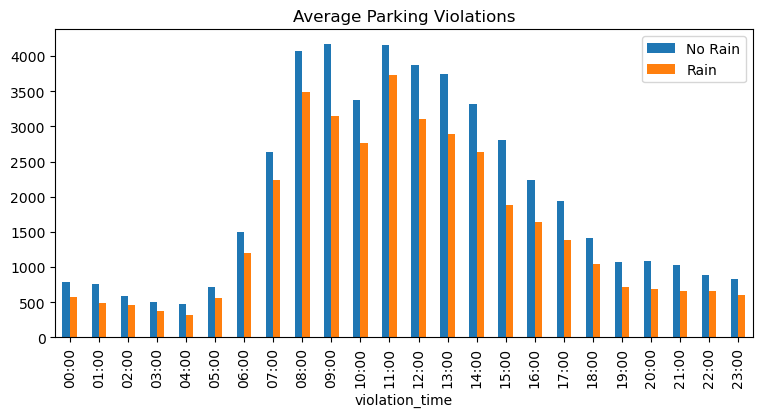

In [431]:
gra=cross_tab_mean.plot(kind='bar', stacked=False,figsize=(9,4))
gra.set_title("Average Parking Violations")

plt.show()

### Is Moderate to Heavy Rain Associated with Parking Violations 

For the previous analysis, I counted every rain data as a rainy hour even if the rain amount was so low. This time I want to dig a bit deeper and see what happens if I only take precipitation data which is over 1 mm. This will definietly reduce the number of rainy days I have, but still I want to see the results.

In [432]:
merged_violation_rain2 = merged_violation.copy()


In [433]:
merged_violation_rain2["precipitation (mm)"] = merged_violation_rain2["precipitation (mm)"].apply(lambda x: 1 if x > 1 else 0)



In [434]:
grouped_for_seeing_counts2 = merged_violation_rain2.groupby(['precipitation (mm)', 'violation_time'])['violation_count'].count().reset_index()


Lets see how many data I have.

In [435]:
grouped_for_seeing_counts2.rename(columns={"violation_count":"Number of days"})

,precipitation (mm),violation_time,Number of days
0,0,00:00,349
1,0,01:00,345
2,0,02:00,348
3,0,03:00,350
4,0,04:00,350
5,0,05:00,351
6,0,06:00,355
7,0,07:00,355
8,0,08:00,351
9,0,09:00,355


It is lower than the previous but still, it can give valuable info. I will perform the cross tabing now.

In [436]:
cross_tab_mean2 = pd.crosstab(index=merged_violation_rain2['violation_time'], columns=merged_violation_rain2['precipitation (mm)'], values=merged_violation_rain2['violation_count'], aggfunc='mean')

In [437]:
cross_tab_mean2.columns=["No Rain","Rain"]

In [438]:
cross_tab_mean2

,No Rain,Rain
violation_time,,
00:00,780.085960,499.000000
01:00,755.660870,507.823529
02:00,590.979885,399.529412
03:00,500.614286,362.750000
04:00,469.574286,322.769231
05:00,715.022792,542.666667
06:00,1485.892958,1136.125000
07:00,2622.943662,1915.142857
08:00,4057.381766,3485.818182


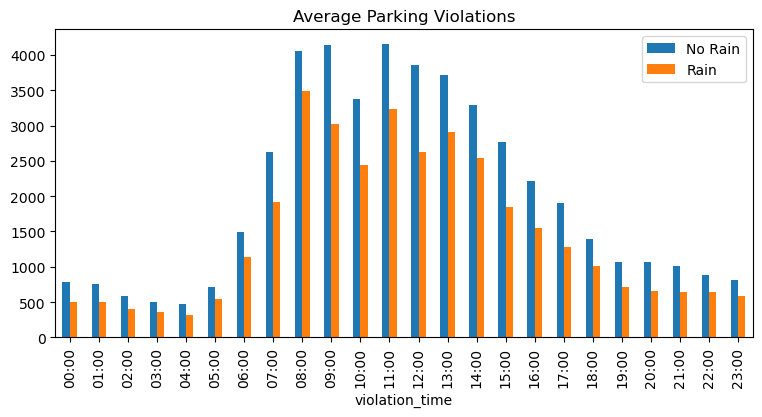

In [217]:
gra=cross_tab_mean2.plot(kind='bar', stacked=False,figsize=(9,4))
gra.set_title("Average Parking Violations")

plt.show()

In [439]:
chi2_contingency(cross_tab_mean2,lambda_="log-likelihood")

Chi2ContingencyResult(statistic=125.97679897990085, pvalue=3.457890154348168e-16, dof=23, expected_freq=array([[ 738.38827065,  540.69768923],
       [ 729.38183173,  534.10256725],
       [ 571.79929237,  418.71000445],
       [ 498.40126611,  364.9630196 ],
       [ 457.40253372,  334.94098276],
       [ 726.0365398 ,  531.65291889],
       [1513.63345871, 1108.38449904],
       [2619.73781436, 1918.34870475],
       [4354.5238863 , 3188.6760619 ],
       [4135.42145231, 3028.2344833 ],
       [3352.50741312, 2454.9320235 ],
       [4265.21030199, 3123.27463209],
       [3745.95157975, 2743.03837647],
       [3824.18552305, 2800.32654591],
       [3370.24512418, 2467.92077177],
       [2665.53373201, 1951.88356416],
       [2180.44568586, 1596.66938207],
       [1843.59784445, 1350.00667532],
       [1389.42881012, 1017.43347889],
       [1027.72395979,  752.56879383],
       [1000.44852881,  732.59588379],
       [ 954.70157385,  699.09687816],
       [ 881.54969817,  645.53014137],

Well, once again, I am surprised. Taking moderate to heavy rain contributed to even less parking violations. The gap is higher now.  

One might say that the p-value is higher in the second case, my explanation would be "the data count indicating rain got shrunk and chi square test is also affected by that". It is also important to remark that it is still highly significant. 

### The Reasons I Can Think of

My previous findings clearly state that rainy hours seemed to have less traffic violations in average, for the time interval I had for my dataframe. That was in contrast to what I initially thought.  

Rain usually makes people go out less and that can be a reason why we are seeing this fall. 

There is one more thing I want to try. The reason I am having this answer might be due to the fact that rain is more common in winter months where I had found out that the amount of violations are lower. If I manage to show that indeed, rain is more common in some months, then I can try to do an analysis only for those months and once again do the comparasion. To try this, first I will check the months where I have the most rain.

In [440]:
merged_violation_rain3=merged_violation.copy()

In [441]:
merged_violation_rain3["precipitation (mm)"] = merged_violation_rain3["precipitation (mm)"].apply(lambda x: 1 if x > 0 else 0)


In [442]:
merged_violation_rain3[merged_violation_rain3["precipitation (mm)"]==1].groupby("month").size().sort_values()

month
Jul    17
Aug    21
Jun    27
May    27
Feb    40
Sep    48
Nov    51
Apr    61
Mar    72
Oct    77
Jan    82
Dec    92
dtype: int64

There are big differences here. Let's also check the violation counts.

In [443]:
merged_violation_rain3.groupby("month").agg({"violation_count":"mean"})

,violation_count
month,
Apr,1930.435146
Aug,2370.607094
Dec,1694.243572
Feb,1907.877612
Jan,1815.610583
Jul,1825.248626
Jun,1870.809182
Mar,2039.916329
May,2034.026882


Again, there are big differences. The lowest violation mean is in December whilst it has 92 rainy hours, leadin the rain list. That might mean I am on the right path.  
As can be seen above, December and January have really high number of rain hours however their violation counts can be considered low when looking at the tables. So what happens if we only take those two months into account and do our analysis? I am curious about "will the number of violations in rainy hours finally exceed the non rainy hours? " question. 

In [444]:
result_jan_dec= merged_violation_rain3[merged_violation_rain3['month'].isin(['Dec', 'Jan'])]


In [445]:
grouped_for_seeing_counts_jan_dec = result_jan_dec.groupby(['precipitation (mm)', 'violation_time'])['violation_count'].count().reset_index()


In [446]:
grouped_for_seeing_counts_jan_dec.rename(columns={"violation_count":"Number of days"})

,precipitation (mm),violation_time,Number of days
0,0,00:00,55
1,0,01:00,57
2,0,02:00,53
3,0,03:00,55
4,0,04:00,58
5,0,05:00,57
6,0,06:00,58
7,0,07:00,54
8,0,08:00,57
9,0,09:00,57


In [447]:
cross_tab_mean_jan_dec = pd.crosstab(index=result_jan_dec['violation_time'], columns=result_jan_dec['precipitation (mm)'], values=result_jan_dec['violation_count'], aggfunc='mean')

In [448]:
cross_tab_mean_jan_dec.columns=["No Rain","Rain"]

In [449]:
cross_tab_mean_jan_dec

,No Rain,Rain
violation_time,,
00:00,822.636364,562.571429
01:00,767.228070,502.000000
02:00,625.207547,440.666667
03:00,525.854545,352.428571
04:00,480.603448,320.250000
05:00,679.157895,583.600000
06:00,1246.017241,962.000000
07:00,2290.870370,2054.285714
08:00,3718.263158,2811.400000


Once again, a similar result. My findings didnt change even if I only take the month January and December.

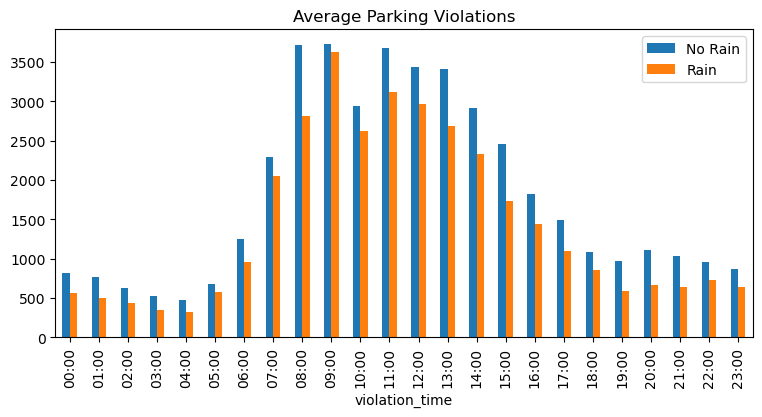

In [450]:
gra=cross_tab_mean_jan_dec.plot(kind='bar', stacked=False,figsize=(9,4))
gra.set_title("Average Parking Violations")

plt.show()

In [451]:
chi2_contingency(cross_tab_mean_jan_dec,lambda_="log-likelihood")

Chi2ContingencyResult(statistic=277.7243266934289, pvalue=1.4073716927215978e-45, dof=23, expected_freq=array([[ 770.87479764,  614.33299457],
       [ 706.3315246 ,  562.89654558],
       [ 593.16412565,  472.71008819],
       [ 488.76877809,  389.51433879],
       [ 445.67879516,  355.17465311],
       [ 702.73084085,  560.02705388],
       [1228.77221289,  979.24502849],
       [2418.10025638, 1927.05582827],
       [3633.78894764, 2895.87421025],
       [4090.79460198, 3260.07557346],
       [3094.96146521, 2466.46660496],
       [3777.55608805, 3010.44650936],
       [3565.93831922, 2841.80203165],
       [3389.31376044, 2701.04468112],
       [2917.96019158, 2325.40903919],
       [2331.96324389, 1858.41068773],
       [1813.1879945 , 1444.9833018 ],
       [1443.38316005, 1150.27485882],
       [1079.92049651,  860.62067996],
       [ 869.77895343,  693.15265035],
       [ 990.09268827,  789.0342348 ],
       [ 932.04007355,  742.77038397],
       [ 934.40126901,  744.65209068],

### Temperature

I will only use this feature because I want to see what happens during extreme weather. This part is not for answering a question or drawing an important conclusion. It is about me being a bit curious.  

In [452]:
merged_violation["Temperature (C)"].max()

35.0

The highest degree measured in NYC, for my dates, is seemed to be 35 degrees. Let's see the violation counts for the respected hours.

In [453]:
merged_violation[merged_violation["Temperature (C)"]==35.0]

,issue_date,violation_time,violation_count,month,precipitation (mm),Temperature (C)
925,2022-08-09,13:00,5034,Aug,0.0,35.0
927,2022-08-09,16:00,2952,Aug,0.0,35.0
928,2022-08-09,17:00,2551,Aug,0.0,35.0


In [454]:
merged_violation["Temperature (C)"].min()

-15.56

The highest degree measured in NYC, for my dates, is seemed to be 35 degrees. Let's see the violation counts for the respected hours and those dates.

In [455]:
merged_violation[merged_violation["Temperature (C)"]==-15.56]

,issue_date,violation_time,violation_count,month,precipitation (mm),Temperature (C)
5199,2023-02-04,06:00,1230,Feb,0.0,-15.56
5200,2023-02-04,07:00,2476,Feb,0.0,-15.56
5201,2023-02-04,08:00,2728,Feb,0.0,-15.56


## Machine Learning Model to Predict Hourly Parking Violations

In [456]:
merged_violation

,issue_date,violation_time,violation_count,month,precipitation (mm),Temperature (C)
0,2022-07-01,01:00,533,Jul,0.0,24.44
1,2022-07-01,02:00,407,Jul,0.0,24.44
2,2022-07-01,03:00,245,Jul,0.0,23.89
3,2022-07-01,04:00,149,Jul,0.0,23.33
4,2022-07-01,05:00,457,Jul,0.0,23.33
...,...,...,...,...,...,...
8685,2023-06-29,20:00,939,Jun,0.0,24.44
8686,2023-06-29,21:00,817,Jun,0.0,23.33
8687,2023-06-29,22:00,891,Jun,0.0,23.33
8688,2023-06-29,23:00,843,Jun,0.0,22.78


I believe I need to define my goal first, I want my model to predict violation counts for a spesific hour. My features will be violation_time, the month, precipiation (I will turn it into a categorical variable with 0 and 1 ). Hence all my features are going to be categorical. I will start preparing my data now.

In [457]:
model_data=merged_violation.copy()

In [458]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8690 entries, 0 to 8689
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   issue_date          8690 non-null   datetime64[ns]
 1   violation_time      8690 non-null   category      
 2   violation_count     8690 non-null   int64         
 3   month               8690 non-null   object        
 4   precipitation (mm)  8690 non-null   float64       
 5   Temperature (C)     8690 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 348.8+ KB


I need to drop unnecessary columns such as issue_date and temperature. Later, I need to convert "month" column to a categorical one.

In [459]:
model_data.drop(["issue_date","Temperature (C)"],axis=1,inplace=True)
model_data["month"] = model_data["month"].astype("category")

model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8690 entries, 0 to 8689
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   violation_time      8690 non-null   category
 1   violation_count     8690 non-null   int64   
 2   month               8690 non-null   category
 3   precipitation (mm)  8690 non-null   float64 
dtypes: category(2), float64(1), int64(1)
memory usage: 154.0 KB


In [460]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8690 entries, 0 to 8689
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   violation_time      8690 non-null   category
 1   violation_count     8690 non-null   int64   
 2   month               8690 non-null   category
 3   precipitation (mm)  8690 non-null   float64 
dtypes: category(2), float64(1), int64(1)
memory usage: 154.0 KB


I will also turn the precipitation columns a categorical one by assigning 1's and 0's.

In [461]:
model_data["precipitation (mm)"]=model_data["precipitation (mm)"].apply(lambda x: 1 if x>0 else 0)

In [462]:
model_data["precipitation (mm)"]=model_data["precipitation (mm)"].astype("category")

In [463]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8690 entries, 0 to 8689
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   violation_time      8690 non-null   category
 1   violation_count     8690 non-null   int64   
 2   month               8690 non-null   category
 3   precipitation (mm)  8690 non-null   category
dtypes: category(3), int64(1)
memory usage: 94.7 KB


My data looks ready now. I will split my target and independent features and perform splitting. I am applying one hot encoding for my categorical features.

In [464]:
X = model_data[['violation_time', 'month', 'precipitation (mm)']]
y = model_data['violation_count']
X = pd.get_dummies(X, columns=['month', 'violation_time',"precipitation (mm)"], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

### A Decision Tree Model

The first model I want to try is a decision tree. I have many categorical columns, thanks to my one hot encoding, and I believe this model can give me a nice answer. 

In [465]:
model2 = DecisionTreeRegressor(random_state=10)
model2.fit(X_train,y_train)
y_pred = model2.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae2 = mean_absolute_error(y_test, y_pred)
print(f" Our Mean Absolute Error= {mae2} and r^2= {r2}")

 Our Mean Absolute Error= 426.9338637500471 and r^2= 0.7968681009896983


I must admit that I got a better result than I expected. R^2 is almost 80%, it gives us a clear idea that our model did well in  explaining a large proportion of the variance in our target. 

I want to try one more time with a more complex model.


### A Random Forest Model

In [466]:
model3 = RandomForestRegressor(random_state=10)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
r22 = r2_score(y_test, y_pred)
mae3 = mean_absolute_error(y_test, y_pred)
print(f" Our Mean Absolute Error= {mae3} and r^2= {r22}")

 Our Mean Absolute Error= 422.50893642548556 and r^2= 0.8021194825368506


We have a slight improvement when trying a random forest model. Again, both performed better than I initially thought on the test data.

## Comments Section

### The Questions I had Planned to Ask the Dataset and Managed to Find My Answers.

I will start by talking about the mini analysis questions I had on my mind: 

*How does the number of parking violations change during different hours of the day?    
*How does the number of parking violations change during different months of the year?   
*How does the number of parking violations change depending on the boroughs of NYC? 

My main question was :

*Are rain and the number of parking violations associated? 

Other things I performed:

*Training a machine learning model to predict hourly parking violations.

### The diffucilties I had

It is important to mention that I was really open on what I did while writing the code. Hence, every difficulty I had can be seen above, along with how I coped with them. Here, I will give even more information about the hard parts of my project from my perspective and how I approached them.  

Initially, I didn't have any clue about how long it would take to ingest a dataset containing of 21 million rows. My first difficulty was finding out that the API link had a limit of 1000 datas per ingestion. I learned how to increase that number by reading the documentation, I remember spending quite some time learning about using that API. Ingesting the data took more than 3 hours. 

Cleaning the data for the columns I needed was another difficulty. The hour and the date columns were really important for me and they were not in the format that I needed them to be. There were also some surprises such as having 00:00 AM and hours like that. Luckily for me, when I had any doubt of any category or feature, I would visit the [NYC Service Center Cite](https://nycserv.nyc.gov/NYCServWeb/NYCSERVMain) and write the summons code which I had for every single data of mine. Then the site would even show me the exact ticket written by the police. That helped me a lot in both understanding the data and also conducting a healhier analysis. Transforming the data to the right format took some effort as well. 

For 5 boroughs of NYC, there were lots of other typos which made it really hard to group them. I renamed them in the right way and then performed my grouping. Resulting in a nice visual representation of the data.  

My next difficulty was finding the hourly weather data for NYC. I know how it sounds, NYC is one of the most popular cities in the world, if not the most, and idea of finding the hourly weather data sounded so easy to me. However, until I found a reliable source where I could ingest the data through an API, I was even considering to pay to a service, which I am really glad that I didn't do. Thanks to the Iowa State University's page which I also mentioned and referenced on my analysis, I was able to handle that.    

The date and the hour part of the weather data required cleaning and transforming once again. Moreover, I was trying to make it look the same as my main frame since I was going to merge them. That too took some time. 

After merging two datasets, I wanted to ask my main question: "Are weather conditions and number of parking violations associated". This was an easy question to ask but finding out how to perform this analysis took some time. Rain was the most suitible data in my opinion. It can affect behaviours hourly and it is a common weather condition. I preffered to do an hourly comparasion of hours with rain and without to see the effects, as I have shown on my analysis, the rainy hours contributed to less parking violations on average. I questioned this outcome with trying other things such as changing counting rain to only counting moderate to heavy rain. Moreover I also did the comparasion for the most rainy hours. In conclusion, I believe I had my answer.   

#### One really really important thing to mention here, 
While I was rounding the hours, I needed to do this to be able to group and also merge two dataframes, I rounded the rain data to the next closest hour beacuse all the rain data I had was at the 51th minute of each hour and it was so much closer to the next hour, in contrast , I rounded the parking data violations to the earliest whole hour.  I thought about this decision a lot, but I think it was the reasonable way to do it and here is my explanation: A rain which is measured at a spesific time effects the upcoming minutes or hours after it's detection. My aproach makes it possible that 1h 9 minutes passes from the detection of rain to the the violation taking place in the worst of the worst scenerio. Even that is kind of acceptable considering the sake of the analysis. The possibility taking the count of a parking violation before it rains, is a really big risk which could lead to wrong answers, at least in my opinion. 

If I have to give an example;

I took the rain data at 22.51 and rounded it to 23.00 . I took the parking violation data for 23.22 and rounded it to 23.00. Hence now I have a parking violation count which is at 23:00. To me, it makes sense this way.

Rounding the rain data to an earlier hour could have been dangerous for the analysis because we simply cant know whether it was raining for that hour and it can be a really bright sunny day just before a heavy rain.

#### Other comparasions

Doing the rest of the comparasions with rain data also took some time, but I would't be content if I hadn't tried other things.

#### Modeling

Modeling was an easier part. After defining the categories, for sure it took less time than cleaning and transforming like other parts of the project. 







### The Time It Took 

It took me three weeks from initiating till the finish of this project. Most of the time spent was "thinking of how to do" instead of "writing code". There were some days which I only spend an hour or so whilst there were some which I needed to spend more than 3-4 hours.

The running of the code didn't take so much time. I don't remember a code which took more than two minutes except the code for ingesting the dataframe. That took more than 3-4 hours.

### The Computing Resources

I used the exact device which I mentioned in my proposal: "Dell Latitude 7490". My processor is Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz   2.11 GHz. I have 16 gb’s of RAM. System :“64-bit operating system, x64-based processor”. It is currently running on Windows 11 Pro.  

Memory usage of the Jupyter Notebook tab varied from 100 MB's to 200 MB's on average on my browser. There were some times that it was more and less.  

I downloaded the first ingested frame to my local device because it was large. I saved it in both csv and parquet format. CSV file took 1.65 GB's of space whilst PARQUET only took 248 mb's.

My whole jupyter notebook took 500 Kb of space.

### The Questions I Planned to Ask but Couldn't Perform the Analysis

#### Again I will start by the minor things,

Analysis on the color of the vehicle, vehicle years, vehicle being registered or unregistered and etc. couldn't be performed due to the fact that there were a lot of null values for those features. I initially thought I could perform some clearing and visualize that by the number of violations as well.

#### A bigger disappointment, a bigger question:

I wanted ask the dataset "Which places in NYC require the most parking spaces? ".That was one of my main initial questions. I couldn't perform this analysis because the data didn't have geopraphical locations of the violations taken place. I have to be open here, the data contained some information on where the violation took place. It had street names , the street codes and also intersecting street names. However, the street code columns had so many null values, street names were not unique and lastly there were nulls which can negatively affect the analysis in all the remaining columns indicating the location. It would have been really good for me if I had the coordinates. All in all, I was unsuccesful at performing this and visualizing my finding on beautiful maps of NYC.  
